# Import

In [1]:
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

import pynndescent

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys
from itertools import combinations
import random
import json
import my_utils

/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# exclude stacktrace

def remove_stacktrace(dataset):
    desc_wo_stacktrace = []
    for point in tqdm(dataset):
        desc = point["description"]
        stacktraces = point["stacktrace"]
        for stacktrace in stacktraces:
            desc = desc.replace(stacktrace["exception"], "")
            if stacktrace["message"] is not None: desc = desc.replace(stacktrace["message"], "")
            if stacktrace["frames"] is not None:
                for frame in stacktrace["frames"]:
                    desc = desc.replace(frame["function"], "")
                    desc = desc.replace(frame["file"], "")
                    desc = desc.replace(str(frame["fileline"]), "")
        desc = desc.replace("\tat ", "")
        desc = desc.replace("at\n", "")
        desc = desc.replace("(:)", "")
        desc = desc.split("\n\n\n\n", 1)[0]
        desc = desc.strip()
        desc_wo_stacktrace.append(desc)
    return desc_wo_stacktrace
        

In [3]:
def get_duplicated_pairs(union_find):
    roots = union_find.get_roots()
    pairs = []
    for root in tqdm(roots):
        group = union_find.get_children(root)
        pairs += list(combinations(group, 2))
    for pair in tqdm(pairs):
        assert(union_find.are_dups(pair[0], pair[1]))
    return pairs

In [4]:
def get_non_duplicated_pairs(union_find, dataset, idx_to_bug_id, size):
    from_dup = union_find.get_all_children()
    #sample in some other single reports
    assert(union_find.processed)
    samples = random.sample(idx_to_bug_id, len(from_dup))
    
    pairs = []
    count = 0
    while (count < size):
        pair = random.sample(samples, 2)
        if pair[0] == pair[1] or union_find.are_dups(pair[0], pair[1]):
            continue
        pairs += [(pair[0], pair[1]),]
        count += 1
    for pair in tqdm(pairs):
        assert(not union_find.are_dups(pair[0], pair[1]))
    return pairs

In [5]:
def top_closest_values_indeces(k, vectors, q):
    # Calculate the absolute differences between each element in L and v
    sim_scores = [(my_utils.similarity_score_1d(v, q), i) for i, v in enumerate(vectors)]
    # differences = [(util.pytorch_cos_sim(v, q), i) for i, v in enumerate(vectors)]

    sim_scores.sort(reverse=True)
    # print(sim_scores[:10])

    # Extract the top k closest values and their indices in the original list
    top_k_indices = [index for _, index in sim_scores[:k]]
    return top_k_indices, sim_scores

# Load data

Data is downloaded from https://zenodo.org/records/5746044#.Yej5HvtyZH6

In [6]:
path_to_datasets = "/home/grads/t/tiendat.ng.cs/github_repos/MLDatasets/EMSE_data"

projects = {"campbell_dataset" : "campbell_stacktraces.json", 
            "eclipse_2018" : "eclipse_stacktraces.json", 
            "gnome_2011" : "gnome_stacktraces.json", 
            "netbeans_2016" : "netbeans_stacktraces.json"}

In [7]:
# loading netbeans 2016 dataset
file_path = os.path.join(path_to_datasets, "netbeans_2016", projects["netbeans_2016"])

try:
    with open(file_path, 'r') as json_file:
        dataset = json.load(json_file)
    # print(dataset)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print(f"File not found: {file_path}")

In [8]:
len(dataset)

65417

In [9]:
num_br_withduplication = 0
for point in dataset:
    if point["dup_id"] is not None:
        num_br_withduplication += 1
print(num_br_withduplication)

13703


In [10]:
idx_to_bug_id = []
for point in dataset:
    idx_to_bug_id.append(point["bug_id"])

In [11]:
union_find = my_utils.UnionFind()
union_find.process_json_data(dataset, "netbeans_2016")

In [12]:
len(union_find.get_roots())

6840

In [13]:
descs_wo_stacktraces = remove_stacktrace(dataset)

  0%|          | 0/65417 [00:00<?, ?it/s]

100%|██████████| 65417/65417 [02:07<00:00, 511.72it/s] 


In [14]:
dataset[1]["description"]

'This is the Windows Eastern European character encoding, and it is being used to load various resources. (The same problem exists in pre-Gandalf versions.) Presumably you set the encoding to this so\n that you can load the _cs.properties files internally without hassle, but it is also the encoder that makes its way into the release builds. This converter is supported by the JDK and should be inclu\nded in any port, but apparently the SGI JDK does not include full I18N support (maybe?) and one person had the following message on startup on Irix (SGI port of JDK 1.1.6):\n\njava.io.UnsupportedEncodingException\n        at sun.io.ByteToCharConverter.getConverter(ByteToCharConverter.java:97)\n\n\n        at java.io.InputStreamReader.<init>(InputStreamReader.java:82)\n        at\ncom.netbeans.developer.util.NetbeansBundle.createResourceBundleFromURL(NetbeansBundle.java:319)\n\n        at\ncom.netbeans.developer.util.NetbeansBundle.findBundle(NetbeansBundle.java:294)\n        at\ncom.netbean

In [15]:
descs_wo_stacktraces[1]

'This is the Windows Eastern European character encoding, and it is being used to load various resources. (The same problem exists in pre-Gandalf versions.) Presumably you set the encoding to this so\n that you can load the _cs.properties files internally without hassle, but it is also the encoder that makes its way into the release builds. This converter is supported by the JDK and should be inclu\nded in any port, but apparently the SGI JDK does not include full I18N support (maybe?) and one person had the following message on startup on Irix (SGI port of JDK 1.1.6):\n\n\n        at \n\n\n        at'

# feeding sbert vector representations to PyNNDescent

## when shot desc is used

### Calculate accuracy. Given a query br, see if all of their duplicates are in top 10

In [102]:
loaded_data = np.load('netbeans_sbert_short_desc.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 65417/65417 [02:15<00:00, 483.55it/s]


In [15]:
Q_set = union_find.get_all_children()

In [76]:
index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")

In [77]:
index.prepare()

/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [83]:
neighbors = index.query(np.array(vectors)[0:20], 11)

In [81]:
neighbors[0][19]

array([   19,  4920, 15049,  7202, 11718,  4251, 22571,   409,  7784,
        2868,  1485], dtype=int32)

In [125]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 20543/20543 [00:31<00:00, 650.08it/s]


In [126]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.3683862248355713 0.43628391174273345
1.0 0.0


(array([10293.,   149.,   164.,   222.,   197.,   204.,   274.,   330.,
           80.,    48.,   461.,    46.,   167.,    45.,     0.,  1117.,
           25.,    56.,    71.,    31.,   343.,    66.,   154.,    37.,
           80.,    76.,    18.,    25.,     0.,  5764.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

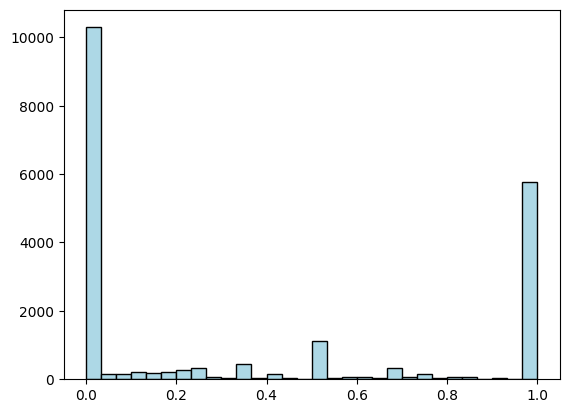

In [127]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [128]:
np.mean(has_duplicate_in_top_5)

0.45076181667721366

(array([11283.,  9260.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

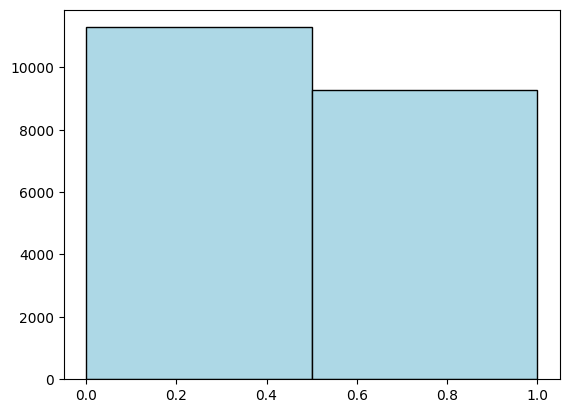

In [130]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

Number of br with no short desc is insignificant

In [34]:
num_br_w_empty_short_desc = 0

for point in dataset:
    short_desc = point["short_desc"]
    if len(short_desc) == 0:
        num_br_w_empty_short_desc += 1

print(num_br_w_empty_short_desc)

4


## when desc with stacktrace is used

In [136]:
loaded_data = np.load('netbeans_sbert_description.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 65417/65417 [01:24<00:00, 769.94it/s]


In [137]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


100%|██████████| 20543/20543 [00:26<00:00, 777.55it/s]


In [138]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.3096289963663367 0.40407849978002436
1.0 0.0


(array([1.0969e+04, 1.6900e+02, 1.9300e+02, 2.5400e+02, 2.0600e+02,
        2.7700e+02, 2.8300e+02, 3.7100e+02, 1.2300e+02, 2.9000e+01,
        6.8100e+02, 5.7000e+01, 2.3800e+02, 3.7000e+01, 7.0000e+00,
        1.3720e+03, 3.1000e+01, 6.0000e+01, 1.0000e+02, 2.1000e+01,
        3.7100e+02, 4.1000e+01, 1.7000e+02, 2.9000e+01, 8.2000e+01,
        3.2000e+01, 1.7000e+01, 1.7000e+01, 0.0000e+00, 4.3060e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

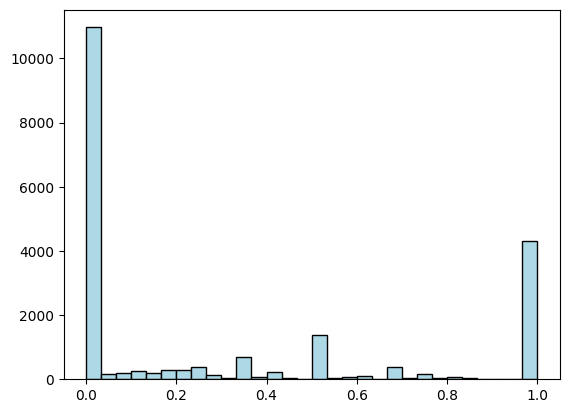

In [139]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [140]:
np.mean(has_duplicate_in_top_5)

0.42097064693569586

(array([11895.,  8648.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

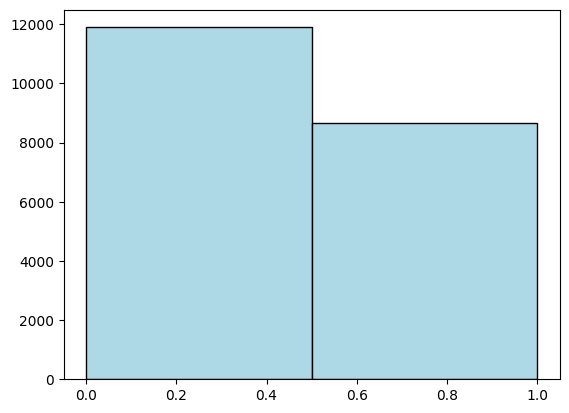

In [141]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

## when desc without stacktrace is used

In [142]:
loaded_data = np.load('netbeans_sbert_description_wo_stacktrace.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 65417/65417 [01:35<00:00, 682.56it/s]


In [143]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 20543/20543 [00:25<00:00, 792.40it/s]


In [144]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.11707573390791866 0.2830871027137146
1.0 0.0


(array([1.635e+04, 1.800e+02, 1.920e+02, 1.910e+02, 1.290e+02, 1.520e+02,
        1.600e+02, 2.340e+02, 3.900e+01, 1.100e+01, 3.430e+02, 1.700e+01,
        7.000e+01, 2.200e+01, 0.000e+00, 6.820e+02, 4.000e+00, 1.000e+01,
        2.100e+01, 3.000e+00, 1.080e+02, 0.000e+00, 4.400e+01, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 0.000e+00, 1.566e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

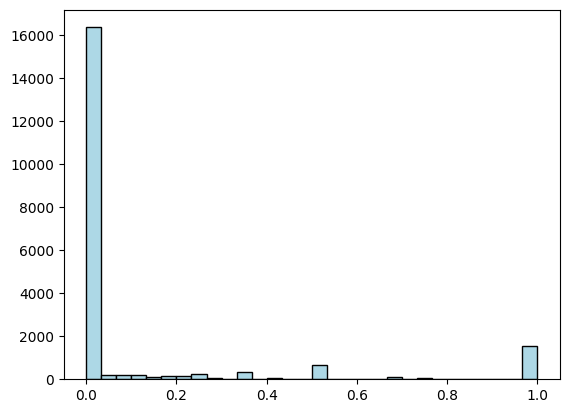

In [145]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [146]:
np.mean(has_duplicate_in_top_5)

0.18074283210826073

(array([16830.,  3713.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

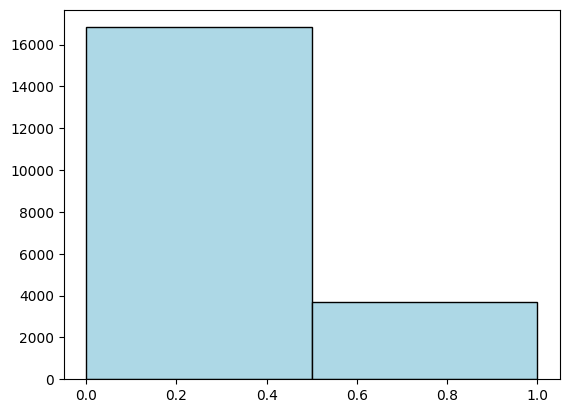

In [147]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

## Print and observe duplicates that are not similar

In [148]:
loaded_data = np.load('netbeans_sbert_description.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 65417/65417 [02:30<00:00, 433.62it/s]


In [149]:
disimilar_duplicates = {}

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for bug_id, children, topk_idx in zip(Q_set, children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_not_in_topk = []
    for child in children:
        if child not in topk:
            children_not_in_topk.append(child)
    if len(children_not_in_topk) != 0:
        disimilar_duplicates[bug_id] = children_not_in_topk
    # children_in_top_k = list(set(children).intersection(set(topk)))
    # accuracy = len(children_in_top_k) / len(children)
    # accuracies.append(accuracy)

# topk_indeces, distances = index.query(Q_vectors, 6)
# for children, topk_idx in zip(children_lists, topk_indeces):
#     topk = [idx_to_bug_id[i] for i in topk_idx]
#     has_dup_in_top = False
#     for child in children:
#         if child in topk:
#             has_dup_in_top = True
#             break
#     if has_dup_in_top:
#         has_duplicate_in_top_5.append(1)
#     else:
#         has_duplicate_in_top_5.append(0)


100%|██████████| 20543/20543 [00:31<00:00, 659.04it/s]


In [150]:
len(disimilar_duplicates.items())

16243

In [152]:
disimilar_duplicates.keys()

dict_keys([9049, 8666, 9246, 8117, 9350, 8868, 8413, 9708, 9702, 9805, 9794, 9879, 9860, 9937, 7213, 10131, 10041, 10140, 10198, 10162, 10220, 9757, 10276, 10202, 10322, 10352, 9944, 10397, 10431, 10403, 10433, 10448, 10559, 10457, 10607, 10493, 10614, 10630, 10709, 10327, 10734, 10890, 10878, 10939, 11031, 10362, 11073, 10265, 11093, 11205, 11275, 11238, 11309, 9082, 11322, 11304, 11409, 7158, 11421, 10459, 11488, 11139, 11498, 11528, 11527, 11559, 11020, 11615, 11769, 11468, 11861, 9160, 11973, 12001, 11952, 12095, 12066, 12096, 11533, 12141, 12170, 9512, 12218, 10609, 12345, 12367, 11450, 12376, 12390, 12400, 12441, 12455, 12460, 12495, 12498, 12488, 12574, 12399, 12590, 12061, 12594, 12541, 12600, 11293, 12640, 12696, 12671, 12762, 12770, 12854, 12896, 12883, 12927, 12410, 12985, 12957, 13007, 13092, 12988, 13121, 13123, 12708, 13153, 12890, 13203, 12436, 13258, 13368, 13405, 12732, 13406, 13433, 12249, 13436, 11443, 13513, 13569, 13059, 13640, 13645, 13649, 13706, 13065, 13752, 13

In [162]:
disimilar_duplicates[8868]

[9350]

In [165]:
union_find.get_children(8868)

[9350, 8868]

In [169]:
print(dataset[idx_to_bug_id.index(8868)]["description"])

System:
Netbeans build 25
JDK: blackdown jdk 1.3.0

The problem can be duplicated as follows:

1. Run a program by clicking the run button in the toolbar.

2. Terminate the program by right-clicking the process in the
   execution window and selecting terminate.

3. return to the GUI editing workspace and run the program again.

4. Terminate the program again using the execution window

4. Return to the GUI editing workspace and once again run the program.

After 2 or 3 times, an unexpected exception will occur.  I have pasted
in the appropriate piece of the log file below (The last exception is the
one that caused the window to pup up):

-------------------------------------------------------------------------------
>Log Session: Monday, December 11, 2000 8:52:03 AM PST
>System Info:
  Product Version          = NetBeans IDE 3.1beta (Build 25)
  IDE Versioning           = IDE/1 spec=1.1.2 impl=Build 25
  Operating System         = Linux Version 2.2.16-5 Running on i386
  Java Version 

In [170]:
print(dataset[idx_to_bug_id.index(9350)]["description"])

Obeying Exception dialog
*********** Exception occurred ************
Fri Feb 02 03:03:19 CET 2001java.lang.IllegalArgumentException: A node
selection cannot contain nodes (<No Processes Running>) not underneath the root
(Processes).
java.lang.IllegalArgumentException: A node selection cannot contain nodes (<No
Processes Running>) not underneath the root (Processes).
	at org.openide.explorer.ExplorerManager.setSelectedNodes
(ExplorerManager.java:138)
	at org.openide.explorer.view.ListView.selectionChanged
(ListView.java:353)
	at org.openide.explorer.view.ListView$Listener.valueChanged
(ListView.java:650)
	at javax.swing.DefaultListSelectionModel.fireValueChanged
(DefaultListSelectionModel.java:170)
	at javax.swing.DefaultListSelectionModel.fireValueChanged
(DefaultListSelectionModel.java:150)
	at javax.swing.DefaultListSelectionModel.fireValueChanged
(DefaultListSelectionModel.java:197)
	at javax.swing.DefaultListSelectionModel.changeSelection
(DefaultListSelectionModel.java:359)
	at ja

## When stacktrace is used

In [171]:
loaded_data = np.load('netbeans_sbert_stacktrace.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 65417/65417 [01:23<00:00, 783.14it/s]


In [172]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


100%|██████████| 20543/20543 [00:27<00:00, 748.54it/s]


In [173]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.6212318459953607 0.4244799036211423
1.0 0.0


(array([ 4832.,    65.,   127.,   159.,   136.,   187.,   261.,   268.,
          144.,   108.,   547.,    57.,   193.,    85.,    25.,  1273.,
           45.,   127.,   185.,    43.,   607.,   103.,   357.,    63.,
          179.,   151.,    38.,    52.,     0., 10126.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

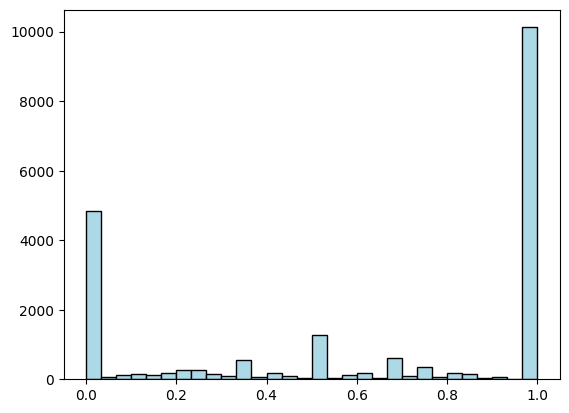

In [174]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [175]:
np.mean(has_duplicate_in_top_5)

0.724480358272891

(array([ 5660., 14883.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

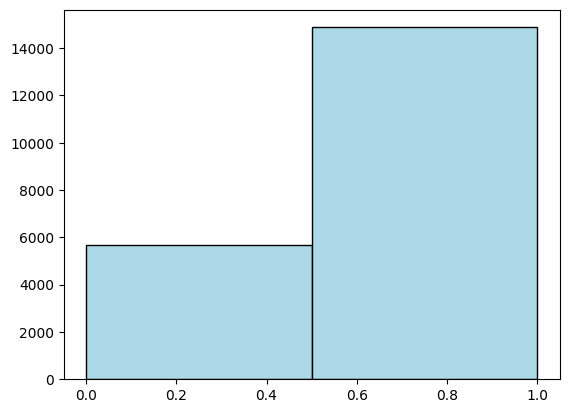

In [176]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

# Retry on eclipse 2018 dataset

In [7]:
# loading netbeans 2016 dataset
file_path = os.path.join(path_to_datasets, "eclipse_2018", projects["eclipse_2018"])

try:
    with open(file_path, 'r') as json_file:
        dataset = json.load(json_file)
    # print(dataset)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print(f"File not found: {file_path}")

In [8]:
len(dataset)

55968

In [9]:
num_br_withduplication = 0
for point in dataset:
    if point["dup_id"] is not None:
        num_br_withduplication += 1
print(num_br_withduplication)

8332


In [10]:
idx_to_bug_id = []
for point in dataset:
    idx_to_bug_id.append(point["bug_id"])

In [11]:
union_find = my_utils.UnionFind()
union_find.process_json_data(dataset, "eclipse_2018")

In [12]:
Q_set = union_find.get_all_children()

In [13]:
len(union_find.get_roots())

4297

In [14]:
descs_wo_stacktraces = remove_stacktrace(dataset)

  1%|          | 387/55968 [00:00<00:17, 3265.43it/s]

100%|██████████| 55968/55968 [00:22<00:00, 2457.55it/s]


## when shot desc is used

### Calculate accuracy. Given a query br, see if all of their duplicates are in top 10

In [15]:
loaded_data = np.load('eclipse_sbert_short_desc.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 55968/55968 [01:04<00:00, 870.73it/s] 


In [16]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 12629/12629 [00:10<00:00, 1261.44it/s]


In [17]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.2588202147653705 0.3867473111168451
1.0 0.0


(array([7.542e+03, 1.470e+02, 1.040e+02, 1.420e+02, 8.600e+01, 1.800e+02,
        2.470e+02, 2.200e+02, 6.900e+01, 1.020e+02, 3.270e+02, 4.000e+01,
        1.140e+02, 4.100e+01, 4.000e+00, 6.470e+02, 8.000e+00, 3.400e+01,
        2.500e+01, 7.000e+00, 1.270e+02, 1.000e+01, 5.400e+01, 1.400e+01,
        1.000e+01, 2.500e+01, 4.000e+00, 3.000e+00, 0.000e+00, 2.296e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

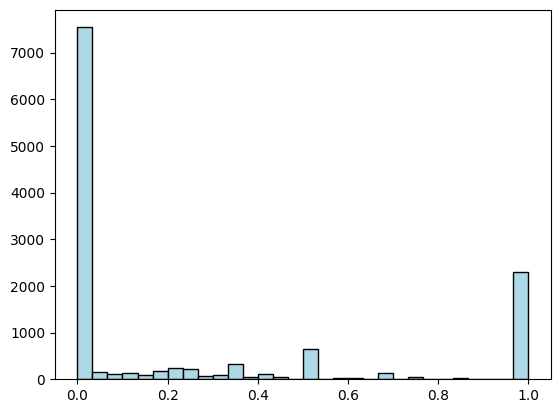

In [18]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [19]:
np.mean(has_duplicate_in_top_5)

0.3611529020508354

(array([8068., 4561.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

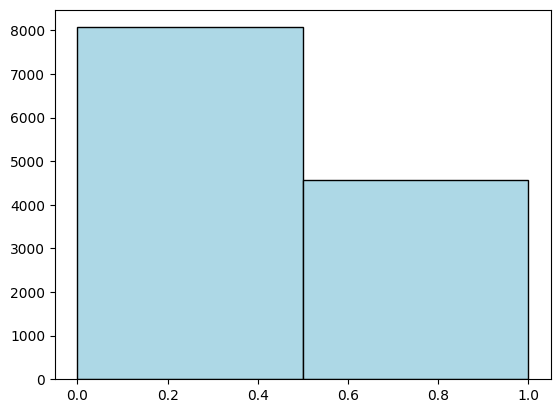

In [20]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

## when desc with stacktrace is used

In [21]:
loaded_data = np.load('eclipse_sbert_description.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 55968/55968 [01:07<00:00, 826.19it/s] 


In [22]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


100%|██████████| 12629/12629 [00:10<00:00, 1235.42it/s]


In [23]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.36216240427025753 0.4222156530878482
1.0 0.0


(array([5.901e+03, 1.190e+02, 2.560e+02, 1.170e+02, 9.500e+01, 1.650e+02,
        2.040e+02, 2.780e+02, 7.500e+01, 4.500e+01, 4.600e+02, 3.600e+01,
        1.420e+02, 2.300e+01, 6.000e+00, 8.700e+02, 2.100e+01, 1.200e+01,
        7.500e+01, 0.000e+00, 2.420e+02, 1.600e+01, 8.400e+01, 1.700e+01,
        4.200e+01, 1.900e+01, 5.000e+00, 1.000e+01, 0.000e+00, 3.294e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

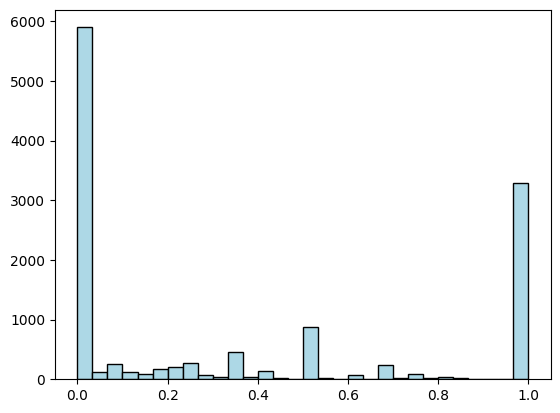

In [24]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [25]:
np.mean(has_duplicate_in_top_5)

0.4863409612795946

(array([6487., 6142.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

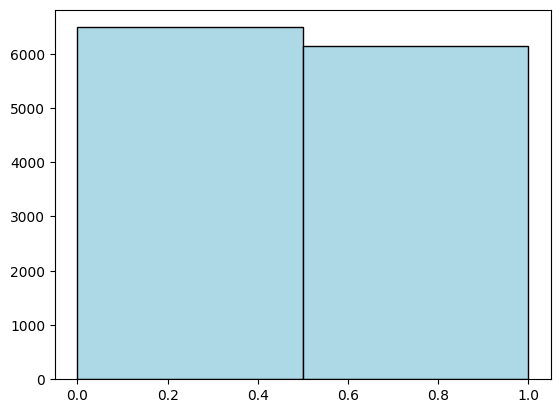

In [26]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

## when desc without stacktrace is used

In [27]:
loaded_data = np.load('eclipse_sbert_description_wo_stacktrace.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 55968/55968 [01:05<00:00, 856.10it/s] 


In [28]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 12629/12629 [00:10<00:00, 1249.06it/s]


In [29]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.22192767337886696 0.3692333944230628
1.0 0.0


(array([8.129e+03, 1.800e+02, 2.030e+02, 1.170e+02, 1.170e+02, 1.380e+02,
        1.640e+02, 1.890e+02, 7.000e+01, 6.400e+01, 3.390e+02, 4.400e+01,
        8.500e+01, 1.400e+01, 6.000e+00, 5.120e+02, 1.800e+01, 1.200e+01,
        2.700e+01, 0.000e+00, 1.150e+02, 1.400e+01, 3.500e+01, 9.000e+00,
        3.400e+01, 7.000e+00, 6.000e+00, 1.100e+01, 0.000e+00, 1.970e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

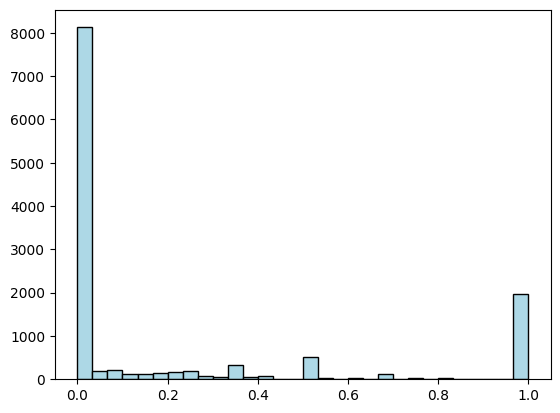

In [30]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [31]:
np.mean(has_duplicate_in_top_5)

0.32393697046480324

(array([8538., 4091.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

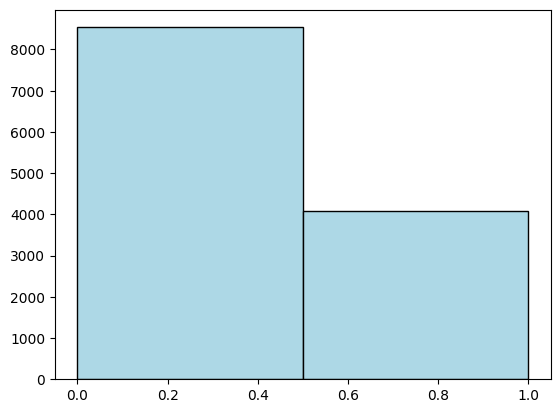

In [32]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)

## When stacktrace is used

In [33]:
loaded_data = np.load('eclipse_sbert_stacktrace.npz')
vectors = [loaded_data[str(b)] for b in tqdm(idx_to_bug_id)]

100%|██████████| 55968/55968 [01:05<00:00, 856.35it/s] 


In [34]:
accuracies = []
has_duplicate_in_top_5 = []

index = pynndescent.NNDescent(np.array(vectors), n_neighbors=100, metric="cosine")
index.prepare()

Q_vectors = np.array([loaded_data[str(bug_id)] for bug_id in tqdm(Q_set)])

# children_lists = [union_find.get_children(bug_id) for bug_id in tqdm(Q_set)]
children_lists = []
for bug_id in tqdm(Q_set):
    children = union_find.get_children(bug_id)
    children.remove(bug_id)
    children_lists.append(children)



topk_indeces, distances = index.query(Q_vectors, 11)

for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    children_in_top_k = list(set(children).intersection(set(topk)))
    accuracy = len(children_in_top_k) / len(children)
    accuracies.append(accuracy)

topk_indeces, distances = index.query(Q_vectors, 6)
for children, topk_idx in zip(children_lists, topk_indeces):
    topk = [idx_to_bug_id[i] for i in topk_idx]
    has_dup_in_top = False
    for child in children:
        if child in topk:
            has_dup_in_top = True
            break
    if has_dup_in_top:
        has_duplicate_in_top_5.append(1)
    else:
        has_duplicate_in_top_5.append(0)


/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 12629/12629 [00:09<00:00, 1280.73it/s]


In [35]:
print(np.mean(accuracies), np.std(accuracies))
print(np.max(accuracies), np.min(accuracies))

0.6561711197175603 0.4234963930003988
1.0 0.0


(array([2.760e+03, 1.060e+02, 1.220e+02, 6.200e+01, 5.000e+01, 4.900e+01,
        7.200e+01, 1.860e+02, 9.200e+01, 8.400e+01, 2.290e+02, 5.000e+01,
        1.350e+02, 8.000e+01, 5.000e+00, 6.710e+02, 5.100e+01, 5.200e+01,
        9.300e+01, 2.000e+00, 2.600e+02, 2.600e+01, 1.380e+02, 6.200e+01,
        1.230e+02, 6.900e+01, 4.100e+01, 1.100e+01, 0.000e+00, 6.948e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

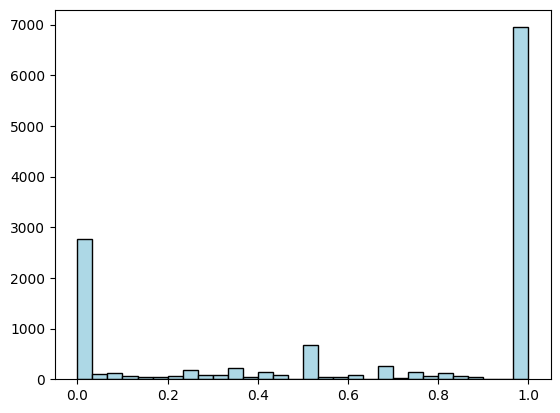

In [36]:
plt.hist(accuracies, color='lightblue', ec='black', bins=30)

In [37]:
np.mean(has_duplicate_in_top_5)

0.7542956686990261

(array([3103., 9526.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

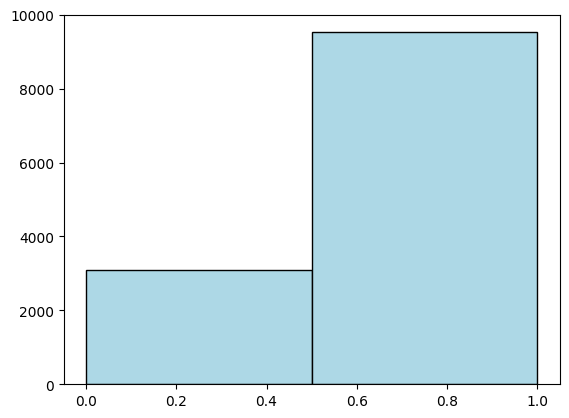

In [38]:
plt.hist(has_duplicate_in_top_5, color='lightblue', ec='black', bins=2)